# TFM: Predicción de la demanda energética - Parte 3: Serie temporal de consumo total de la muestra de clientes (CU 1)
#### Lara Palacios

En este caso de uso, vamos a analizar la serie temporal del consumo total de la red de clientes.

## 0. Importación de librerías

In [1]:
!pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 560.6/560.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.7 MB/s eta 0:00:00


In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.1 MB/s eta 0:00:00


In [3]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 5.1 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import json
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from io import StringIO
import contextlib
import re
import gc
import warnings

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import backtesting_forecaster, bayesian_search_forecaster, grid_search_forecaster
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax, grid_search_sarimax

from pmdarima import ARIMA
from pmdarima import auto_arima

from lightgbm import LGBMRegressor
import plotly.graph_objects as go

import shap

pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore')

In [5]:
#### caso de uso2: Serie temporal del consumo de un cliente en particular
#Seleccionemos un cliente entre aquellos que hemos visto que tenían la serie temporal completa.

#### caso de uso3: Serie temporal del consumo medio de cada municipio/provincia
#Agrupamos los clientes por municipio y establecemos un consumo medio.

## 3. Preparación de los datos

En este cuaderno trabajaremos solo con la serie temporal de la variable CONSUMO:

In [6]:
variable = 'CONSUMO'

### 3.2. Integridad de la serie temporal

#### 3.2.0. Carga de los datos

In [7]:
#conexión a google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df_preprocesado = pd.read_parquet('/content/drive/MyDrive/TFM/df_preprocesado_red.parquet')
df_preprocesado.shape

(15140750, 26)

In [9]:
seleccionar_clientes = pd.read_parquet('/content/drive/MyDrive/TFM/seleccionar_clientes.parquet')
seleccionar_clientes.shape

(11137, 4)

Añadiendo condiciones sobre el dataframe 'seleccionar_clientes' podemos descartar a clientes que no cumplan condiciones de integridad.

In [10]:
filtro_clientes = seleccionar_clientes[(seleccionar_clientes['FILAS_NA'] == 0) & (seleccionar_clientes['INICIO'] == seleccionar_clientes['INICIO'].min())].reset_index(drop = True)
filtro_clientes.shape

(9781, 4)

In [11]:
df = df_preprocesado[df_preprocesado['PK_CLIENTE'].isin(filtro_clientes['PK_CLIENTE'])]
df.shape

(13510134, 26)

In [12]:
#para liberar espacio de la RAM en Google Colab
del filtro_clientes
gc.collect()
filtro_clientes=pd.DataFrame()

#### 3.2.1. Formato de serie temporal

Veamos cuantos datos de clientes distintos tenemos para cada día de la serie. Así aseguraremos que tenemos una serie con las mismas condiciones en cada día.

In [13]:
clientes_por_fecha = df.groupby(df.PK_ANYOMESDIA).agg({'PK_CLIENTE': 'nunique'}).rename(columns={'PK_CLIENTE': 'count_PK_CLIENTE'}).reset_index()
clientes_por_fecha['PK_ANYOMESDIA'] = clientes_por_fecha['PK_ANYOMESDIA'].dt.date

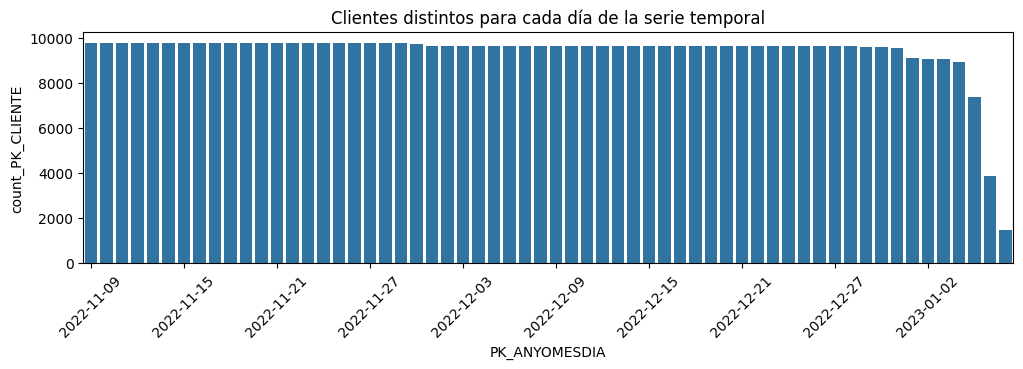

In [14]:
plt.figure(figsize=(12, 3))
sns.barplot(x = "PK_ANYOMESDIA", y = "count_PK_CLIENTE", data = clientes_por_fecha)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
plt.title('Clientes distintos para cada día de la serie temporal')
plt.show()

Vemos que para los últimos días se reduce notablemente el número de clientes para los que tenemos datos. Calculamos los outliers de nuevo con el método del rango intercuartílico y así los eliminamos de nuestra serie temporal.

In [15]:
Q1 = clientes_por_fecha['count_PK_CLIENTE'].quantile(0.25)
Q3 = clientes_por_fecha['count_PK_CLIENTE'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

df_filtrado = clientes_por_fecha[(clientes_por_fecha['count_PK_CLIENTE'] >= limite_inferior) & (clientes_por_fecha['count_PK_CLIENTE'] <= limite_superior)]
fecha_min = df_filtrado['PK_ANYOMESDIA'].min()
fecha_max = df_filtrado['PK_ANYOMESDIA'].max()

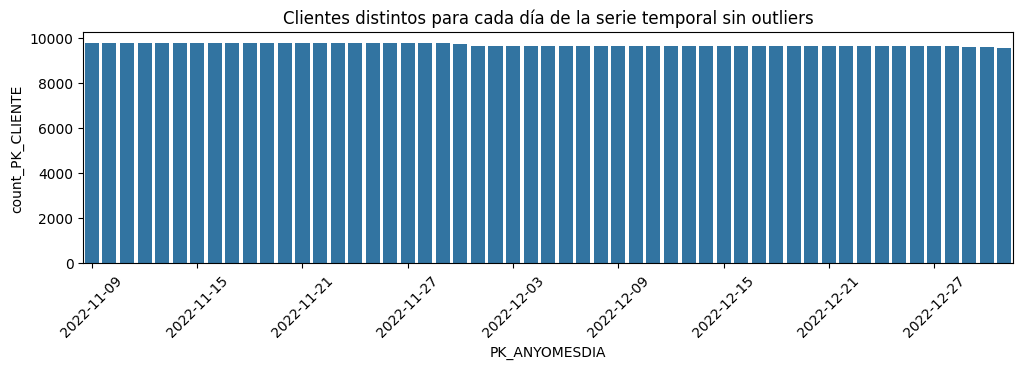

In [16]:
plt.figure(figsize=(12, 3))
sns.barplot(x = "PK_ANYOMESDIA", y = "count_PK_CLIENTE", data = df_filtrado)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
plt.title('Clientes distintos para cada día de la serie temporal sin outliers')
plt.show()

In [17]:
#para liberar espacio de la RAM en Google Colab
del df_filtrado
gc.collect()
df_filtrado=pd.DataFrame()

Así pues, consideraremos solo estos días en nuestra serie temporal del consumo total de la red de clientes. Además, también nos quedamos solo con los clientes que tengan datos para todos estos días.

In [18]:
filtro_clientes_2 = seleccionar_clientes[(seleccionar_clientes['FILAS_NA'] == 0) & (seleccionar_clientes['INICIO'] == seleccionar_clientes['INICIO'].min()) & (seleccionar_clientes['FIN'].dt.date > fecha_max)].reset_index(drop = True)
df = df_preprocesado[df_preprocesado['PK_CLIENTE'].isin(filtro_clientes_2['PK_CLIENTE'])]
df = df[(df['DATETIME'].dt.date >= fecha_min) & (df['DATETIME'].dt.date <= fecha_max)]
df.shape

(11605728, 26)

In [19]:
#para liberar espacio de la RAM en Google Colab
del df_preprocesado
gc.collect()
df_preprocesado=pd.DataFrame()

In [20]:
#para liberar espacio de la RAM en Google Colab
del filtro_clientes_2
gc.collect()
filtro_clientes_2=pd.DataFrame()

Seleccionamos alguna variable más que luego nos servirá para añadir como variable exógena al modelo predictivo:

In [21]:
df['ORTO_minutos'] = df['ORTO'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
df['OCASO_minutos'] = df['OCASO'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
df['%_CIELO_DESPEJADO'] = np.where(df['DESCRIPCION'] == 'Despejado',100,0)

In [22]:
df_consumo_total = df.groupby(df['DATETIME']).agg({variable: 'sum', 'TEMPERATURA':'mean', '%_CIELO_DESPEJADO':'mean', 'ORTO_minutos':'mean', 'OCASO_minutos':'mean'})
df_consumo_total = df_consumo_total.asfreq('H')
#df_consumo_total = df_consumo_total.set_index('DATETIME').asfreq('H')

In [23]:
#para liberar espacio de la RAM en Google Colab
del df
gc.collect()
df=pd.DataFrame()

Así obtenemos una serie temporal con los mismos clientes para cada valor del índice. Notar que vamos a trabajar con 9.124 clientes de los 11.786 que teníamos inicialmente.

Con el agrupamiento por la columna DATETIME, ya se establece esta como índice (que es lo que nos interesa). Esta tarea nos facilitará a la hora de hacer futuras operaciones con ella.

Comprobamos ahora que nuestra serie temporal está completa:

In [24]:
(df_consumo_total.index == pd.date_range(start=df_consumo_total.index.min(), end=df_consumo_total.index.max(), freq='H')).all()

True

In [25]:
print(f"Filas con valores ausentes: {df_consumo_total.isnull().any(axis=1).mean()}")

Filas con valores ausentes: 0.0


#### 3.2.2. Variables exógenas

Podemos introducir otras variables de las cuáles podría depender también el consumo de un hogar, y que se incluyen típicamente en análisis de series temporales como son: el día de la semana y el indicador de si es fin de semana o no.
Las usaremos más adelante para cuando queramos incluir variables exógenas a nuestros modelos predictivos.

In [26]:
def minutos_a_formato_h(var_minutos):
    horas = int(var_minutos // 60)
    minutos = int(var_minutos % 60)
    var_formateada = f"{horas:02d}:{minutos:02d}"
    var_formateada = pd.to_datetime(var_formateada, format='%H:%M').hour
    return var_formateada

In [27]:
#variables de calendario
df_consumo_total['HORA'] = df_consumo_total.index.hour #+1
df_consumo_total['DIA_SEMANA'] = df_consumo_total.index.dayofweek #+1
df_consumo_total['FIN_DE_SEMANA'] = (df_consumo_total['DIA_SEMANA'] >= 5).astype(int)
#variables de luz solar
df_consumo_total['H_LUZ_SOLAR'] = (df_consumo_total['OCASO_minutos'] - df_consumo_total['ORTO_minutos'])
df_consumo_total['H_LUZ_SOLAR'] = df_consumo_total['H_LUZ_SOLAR'].apply(minutos_a_formato_h)
df_consumo_total['ORTO'] = df_consumo_total['ORTO_minutos'].apply(minutos_a_formato_h)
df_consumo_total['OCASO'] = df_consumo_total['OCASO_minutos'].apply(minutos_a_formato_h)
df_consumo_total["ES_DE_DIA"] = np.where((df_consumo_total.index.hour>df_consumo_total["ORTO"]) & (df_consumo_total.index.hour<df_consumo_total["OCASO"]),1,0)
df_consumo_total = df_consumo_total.drop(columns = ['OCASO_minutos', 'ORTO_minutos'])

In [28]:
df_consumo_total.head()

,CONSUMO,TEMPERATURA,%_CIELO_DESPEJADO,HORA,DIA_SEMANA,FIN_DE_SEMANA,H_LUZ_SOLAR,ORTO,OCASO,ES_DE_DIA
DATETIME,,,,,,,,,,
2022-11-09 00:00:00,7163.416,14.036716,2.444103,0,2,0,10,7,17,0
2022-11-09 01:00:00,6724.624,13.749014,0.997370,1,2,0,10,7,17,0
2022-11-09 02:00:00,6453.883,14.103354,1.446734,2,2,0,10,7,17,0
2022-11-09 03:00:00,6413.837,13.727970,0.230162,3,2,0,10,7,17,0
2022-11-09 04:00:00,6561.450,13.342722,0.295923,4,2,0,10,7,17,0


In [29]:
#Crear dataframe variables exógenas
exog_cols = ['FIN_DE_SEMANA', 'H_LUZ_SOLAR', 'ES_DE_DIA']

Una vez tenemos ya extraídas todas las variables exógenas que nos interesan, hagamos algunos pasos adicionales.

##### Variables con patrones cíclicos

Algunos aspectos del calendario, como las horas o los días, son cíclicos. Así, este tipo de variables pueden transformarse para captar la ciclicidad de estos datos, utilizando el seno y el coseno de su periodo, y evitar imponer un orden lineal.

In [30]:
def codificacion_ciclica(datos, longitud_ciclo): #Se asume que el valor mínimo de la variable es 0
    seno = np.sin(2 * np.pi * datos/longitud_ciclo)
    coseno = np.cos(2 * np.pi * datos/longitud_ciclo)
    resultado =  pd.DataFrame({f"{datos.name}_seno": seno, f"{datos.name}_coseno": coseno})
    return resultado

DIA_SEMANA_encoded = codificacion_ciclica(df_consumo_total['DIA_SEMANA'], longitud_ciclo=7)
HORA_encoded = codificacion_ciclica(df_consumo_total['HORA'], longitud_ciclo=24)
ORTO_encoded = codificacion_ciclica(df_consumo_total['ORTO'], longitud_ciclo=24)
OCASO_encoded = codificacion_ciclica(df_consumo_total['OCASO'], longitud_ciclo=24)
variables_ciclicas = pd.concat([DIA_SEMANA_encoded, HORA_encoded,ORTO_encoded,OCASO_encoded], axis=1)
df_consumo_total = pd.concat([df_consumo_total, variables_ciclicas], axis=1)

In [31]:
exog_cols.extend(df_consumo_total.filter(regex='_seno$|_coseno$').columns.tolist())

##### Interacción entre variables

En ocasiones, las variables exógenas no son independientes. Podemos capturar esta interacción mediante nuevas variables (que se obtienen multiplicando entre sí las variables existentes).

In [32]:
transformer_poly = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False).set_output(transform="pandas")
poly_cols = ['FIN_DE_SEMANA','DIA_SEMANA_seno','DIA_SEMANA_coseno','HORA_seno','HORA_coseno','H_LUZ_SOLAR','ES_DE_DIA','ORTO_seno','ORTO_coseno','OCASO_seno','OCASO_coseno']

variables_poly = transformer_poly.fit_transform(df_consumo_total[poly_cols].dropna()).drop(columns=poly_cols)
variables_poly.columns = [f"poly_{col}" for col in variables_poly.columns]
variables_poly.columns = variables_poly.columns.str.replace(" ", "__")
df_consumo_total = pd.concat([df_consumo_total, variables_poly], axis=1)

In [33]:
exog_cols.extend(df_consumo_total.filter(regex='^poly_.*').columns.tolist())

#### 3.2.3. Separación de los datos en conjuntos de train, validation y test

Para poder optimizar los hiperparámetros del modelo y evaluar su capacidad predictiva, se dividen los datos en 3 conjuntos, uno de entrenamiento, uno de validación y otro de test.

Notar que en el caso de series temporales no hay que aislar la variable target del resto, pues los valores pasados de esta variable se utilizan para su predicción.

In [34]:
df_consumo_total['DIA'] = df_consumo_total.index.date
dias = df_consumo_total['DIA'].unique()
n_dias = len(dias)

dias_train = int(n_dias * 0.6)
dias_validation = int(n_dias * 0.3)
dias_test = n_dias - dias_train - dias_validation

train_data = df_consumo_total[df_consumo_total['DIA'].isin(dias[:dias_train])]
validation_data = df_consumo_total[df_consumo_total['DIA'].isin(dias[dias_train:dias_train + dias_validation])]
test_data = df_consumo_total[df_consumo_total['DIA'].isin(dias[dias_train + dias_validation:])]

print("---Serie temporal del consumo total de la red de clientes---")
print(f"Fechas train      : {train_data.index.min()} --- {train_data.index.max()}  (n={len(train_data)})")
print(f"Fechas validacion : {validation_data.index.min()} --- {validation_data.index.max()}  (n={len(validation_data)})")
print(f"Fechas test       : {test_data.index.min()} --- {test_data.index.max()}  (n={len(test_data)})")

---Serie temporal del consumo total de la red de clientes---
Fechas train      : 2022-11-09 00:00:00 --- 2022-12-09 23:00:00  (n=744)
Fechas validacion : 2022-12-10 00:00:00 --- 2022-12-24 23:00:00  (n=360)
Fechas test       : 2022-12-25 00:00:00 --- 2022-12-31 23:00:00  (n=168)


In [35]:
#eliminar columna DIA

## 4. Exploración gráfica

Lo normal es que una serie temporal que representa la demanda eléctrica tenga estacionalidad anual, pues depende en que mes estemos, la climatología influye en el consumo eléctrico. Sin embargo, debido a que nuestro dataset apenas tiene 2 meses de histórico, no podemos tener esto en cuenta. Tendremos más en cuenta la estacionalidad a nivel día de la semana y a nivel hora del día.

### 4.1. Representación gráfica de la serie temporal
Con separación de datos de train, validación y test.

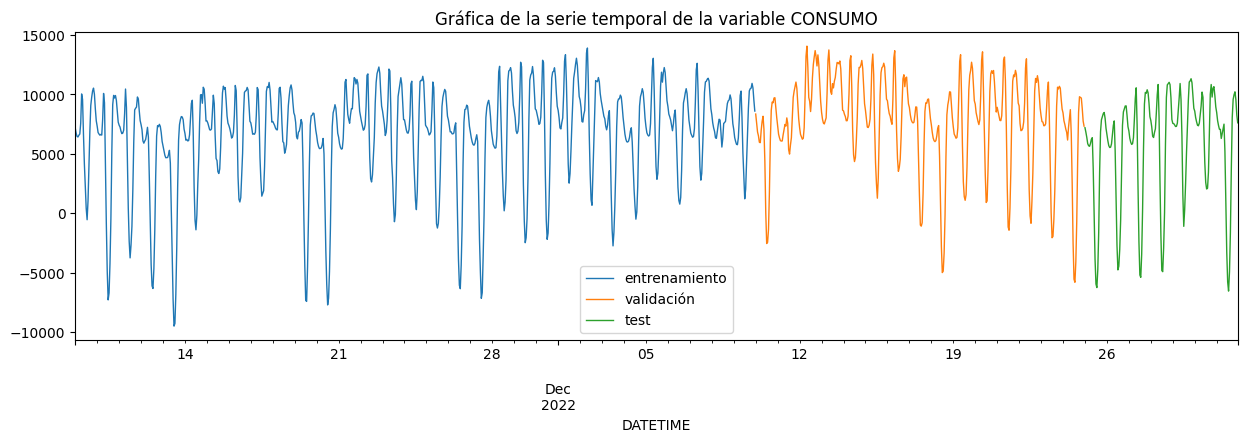

In [36]:
fig, ax = plt.subplots(figsize=(15, 4))
train_data[variable].plot(ax=ax, label= 'entrenamiento', linewidth=1)
validation_data[variable].plot(ax=ax, label= 'validación', linewidth=1)
test_data[variable].plot(ax=ax, label= 'test', linewidth=1)
ax.set_title(f'Gráfica de la serie temporal de la variable {variable}')
ax.legend()

Observaciones.
- La serie muestra una clara periodicidad, con picos y valles regulares que podrían corresponder a ciclos diarios de consumo eléctrico. También se pueden observar levemente los ciclos semanales de consumo.
- Existen variaciones significativas en los valores de la variable consumo.
- Notar que para los periodos de validación y test, la periodicidad y amplitud de las fluctuaciones parecen seguir patrones similares a los observados en el conjunto de train, lo que sugiere que el comportamiento de la variable es consistente a lo largo del tiempo. Por lo tanto, no hay problema en que solo tengamos un histórico de datos inferior a 2 meses.

### 4.2. Distribución de la carga por día de la semana

Text(0.5, 0.98, '')

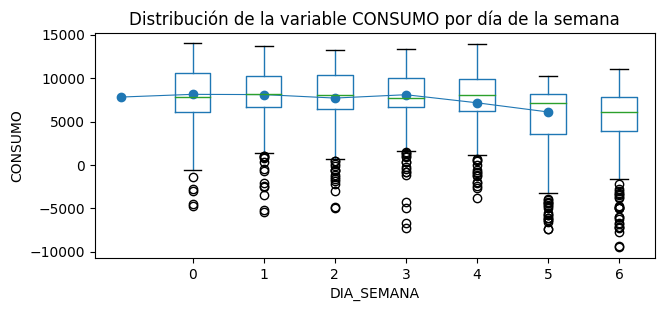

In [37]:
fig, ax = plt.subplots(figsize=(7, 3))
df_consumo_total.boxplot(column=variable, by='DIA_SEMANA', ax=ax)
df_consumo_total.groupby('DIA_SEMANA')[variable].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel(variable)
ax.set_title(f'Distribución de la variable {variable} por día de la semana')
fig.suptitle('')

Observaciones.
- El consumo tiende a mantenerse relativamente constante.
- La altura de la caja es similar para todos los días, indicando una dispersión similar del consumo.
- Hay una cantidad significativa de outliers negativos. Esto se debe a los picos de producción de energía solar en la variable SALIDA, que afectan en CONSUMO.
- Se observa un menor consumo de electricidad los fines de semana.

### 4.3. Distribución de la carga por hora del día

Text(0.5, 0.98, '')

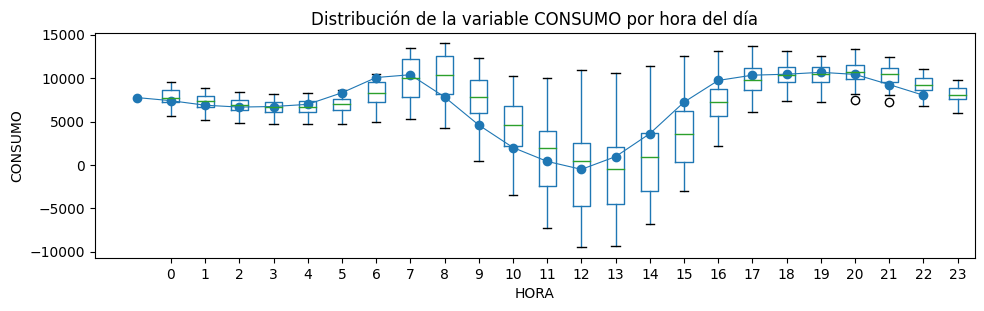

In [38]:
fig, ax = plt.subplots(figsize=(11, 3))
df_consumo_total['HORA'] = df_consumo_total.index.hour
df_consumo_total.boxplot(column=variable, by='HORA', ax=ax)
df_consumo_total.groupby('HORA')[variable].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel(variable)
ax.set_title(f'Distribución de la variable {variable} por hora del día')
fig.suptitle('')

Observaciones.
- El consumo de energía tiene dos picos principales: uno por la mañana alrededor de las 8 horas y otro por la tarde entre las 18 y las 20 horas. Esto es debido probablemente a los momentos de mayor actividad en los hogares, como el inicio del día y las horas de la tarde-noche cuando las personas vuelven a casa.
- La variabilidad en el consumo de energía es mayor durante los picos de actividad y menor durante la noche.
- Notar también que los periodos de menor consumo coinciden con las horas de mayor radiación solar (las horas centrales del día). Lo cual podría indicar que durante estas horas, la producción solar podría estar cubriendo una mayor parte de la demanda, reduciendo la necesidad de consumo de la red y llegando a producir hasta un excedente (ya que hay bastantes valores negativos).

## 5. Creación y entrenamiento del modelo

Empezaremos haciendo lo que se conoce como modelo *baseline*, que nos servirá de referencia para evaluar si merece la pena aplicar modelos más complejos. La métrica del error se utilizará como referencia para comparar la capacidad predictiva de los modelos más complejos.

Mientras no trabajemos con el conjunto de validación, tomaremos como conjunto de train el conjunto de train y validación.

In [39]:
train_val_data = pd.concat([train_data, validation_data], axis=0)

In [40]:
tabla_comparacion_modelos = pd.DataFrame(columns=['MODELO', 'MAE', 'MSE', 'RMSE'])

def guardar_results(modelo, mae, mse, rmse, tabla_comparacion_modelos):
  tabla_comparacion_modelos = pd.concat([tabla_comparacion_modelos, pd.DataFrame({'MODELO': modelo, 'MAE': mae, 'MSE': mse, 'RMSE': rmse}, index=[0])], ignore_index=True)
  return tabla_comparacion_modelos

### 5.1. Baseline

A la hora de abordar un problema de forecasting, es recomendable tener un modelo de referencia (baseline). Se trata generalmente de un modelo bastante simple que puede utilizarse como referencia para determinar si merece la pena implementar modelos más complejos.

La librería *Skforecast* facilita la creación de un baseline utilizando su clase *ForecasterEquivalentDate*. Este modelo simplemente devuelve el valor observado en el mismo período de la temporada anterior. En este caso, el modelo predice el valor del día siguiente utilizando el valor de la misma hora y del mismo día de la semana anterior.

Una vez entrenado el modelo, evaluaremos su capacidad predictiva mediante un proceso de backtesting. El proceso de backtesting consiste en generar una predicción para cada observación del conjunto de test y finalmente comparar el valor predicho con el valor real.

El proceso de backtesting se aplica mediante la clase *backtesting_forecaster()*, y la métrica de error utilizada es el error absoluto medio (MAE).

In [70]:
def all_metrics(prediccion, test_data):
    metrics = {}
    metrics['MAE'] = mean_absolute_error(test_data[variable], prediccion)
    metrics['MSE'] = mean_squared_error(test_data[variable], prediccion)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    return metrics

In [42]:
def backtesting(forecaster, df, train_data, test_data, exog_cols=None):
    if exog_cols is not None:
        exog = df[exog_cols]
    else:
        exog = None
    params = {
        'forecaster': forecaster,
        'y': df[variable],
        'exog': exog,
        'steps': 24,
        'metric': 'mean_absolute_error',
        'initial_train_size': len(df[variable].loc[:train_data.index.max()]),
        'n_jobs': 'auto',
        'verbose': False,
        'show_progress': True,
        'fixed_train_size': False,
        'refit': True
    }
    if isinstance(forecaster, ForecasterSarimax):
        metric, predictions = backtesting_sarimax(**params)
    else:
        metric, predictions = backtesting_forecaster(**params)

    metrics = all_metrics(predictions, test_data)
    print(f"Métricas de error: {metrics}")

    fig, ax = plt.subplots(figsize=(11, 3))
    train_data[variable].plot(ax=ax, label='train')
    test_data[variable].plot(ax=ax, label='test')
    predictions.plot(ax=ax, label='predicciones')
    ax.set_title(f'Predicción sobre la variable {variable}')
    ax.legend()

    return metrics

In [43]:
params = {
    'offset': pd.DateOffset(days=7),
    'n_offsets': 1
}
baseline = ForecasterEquivalentDate(**params)

  0%|          | 0/7 [00:00<?, ?it/s]

Métricas de error: {'MAE': 1696.8574821428574, 'MSE': 5602338.779176077, 'RMSE': 2366.926018948644}


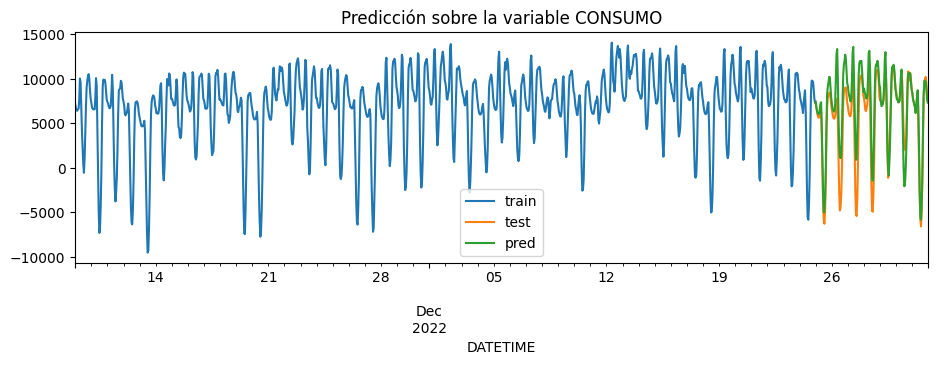

In [44]:
metrics = backtesting(baseline, df_consumo_total, train_val_data, test_data)
tabla_comparacion_modelos = guardar_results(f'ForecasterEquivalentDate({params})', metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

Una vez tenemos un baseline, probemos a modelar la serie mediante un tipo de modelo estadístico muy usado para series temporales: ARIMA y sus variantes.

### 5.2. ARIMA (AutoRegressive Integrated Moving Average)

Es un modelo clásico de series temporales que puede capturar tanto la estacionalidad como las tendencias en los datos. Combina tres componentes:
- $AR$ (AutoRegressive): Este componente usa la relación dependiente entre una observación y un número de rezagos (lag) de la misma.
- $I$ (Integrated): Esta parte del modelo utiliza la diferencia de las observaciones para hacer la serie temporal estacionaria.
- $MA$ (Moving Average): Este componente modela el error de la serie temporal como una combinación lineal de errores de observaciones pasadas.

Un modelo ARIMA se denota como ARIMA(p,d,q):
- $p$ es el orden del componente autoregresivo.
- $d$ es el grado de diferenciación.
- $q$ es el orden del componente de media móvil.

Notar que $ARIMA(1,0,0) = AR(1)$, $ARIMA(0,1,0) = I(1)$, y $ARIMA(0,0,1) = MA(1)$.

#### 5.2.1. Análisis exploratorio de la serie

Antes de aplicar ARIMA, es necesario:

1. **Verificar Estacionariedad**

Observando la gráfica de la serie temporal, parece que la media y la varianza permanencen más o menos constantes, lo cuál es un indicador de estacionaridad. Pero para asegurarnos, aplicaremos la prueba de **Dickey Fuller aumentada** y la de **Kwiatkowski-Phillips-Schmidt-Shin (KPSS)**.

In [45]:
def test_estacionariedad(df): ## tengo dudas sobre si esto se aplica sobre todo el conjunto o solo sobre el de train
    print(f'Test estacionariedad para la serie de la variable {variable}')
    print('--------------------------------------------------------------')
    adfuller_result = adfuller(df[variable])
    kpss_result = kpss(df[variable])
    print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
    print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

In [46]:
test_estacionariedad(train_val_data)

Test estacionariedad para la serie de la variable CONSUMO
--------------------------------------------------------------
ADF Statistic: -2.169701462379079, p-value: 0.2174252348423839
KPSS Statistic: 0.996180952074618, p-value: 0.01


Notar que en los tres casos, para la prueba DF el p-value es superior a 0.05, luego se considera que las tres series no son estacionarias y es necesario diferenciar. Aunque, la prueba KPSS es superior a 0.05 en el último caso, indicando entonces que la serie es estacionaria, al tener un resultado un poco contradictorio, probaremos diferenciando igualmente.

In [47]:
train_data_diff_1 = train_val_data.diff().dropna()

In [48]:
test_estacionariedad(train_data_diff_1)

Test estacionariedad para la serie de la variable CONSUMO
--------------------------------------------------------------
ADF Statistic: -9.47955197636409, p-value: 3.9061257968388734e-16
KPSS Statistic: 0.004021358441256896, p-value: 0.1


Ahora los valores de los p-values si que están en el umbral que deben estar para todas las variables y pruebas. Por lo tanto:

In [49]:
d = 1

Pintemos las gráficas de las series diferenciadas:

<Axes: title={'center': 'Diferenciación de orden 1 de la serie de la variable CONSUMO'}, xlabel='DATETIME'>

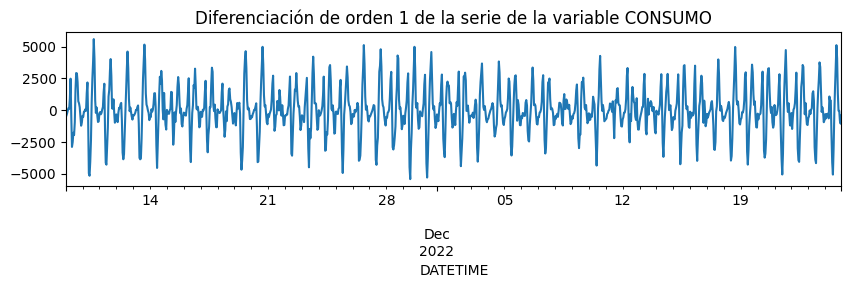

In [50]:
fig, ax = plt.subplots(figsize=(10, 2))
train_data_diff_1[variable].plot(ax=ax, title=f'Diferenciación de orden 1 de la serie de la variable {variable}')

Los análisis posteriores debemos realizarlos con la serie diferenciada.

2. **Análisis de autocorrelación**

Los gráficos de autocorrelación muestran la correlación entre una serie temporal y sus valores pasados. Son una herramienta útil para identificar el orden de un modelo autorregresivo, es decir, los valores pasados (lags) que se deben incluir en el modelo.

- La función de autocorrelación (ACF) mide la correlación entre una serie temporal y sus valores pasados.
- La función de autocorrelación parcial (PACF) mide la correlación entre una serie temporal y sus valores pasados, pero solo después de eliminar las variaciones explicadas por los valores pasados intermedios.

La ACF ayuda a identificar el valor de $q$ (lags en la parte de media móvil), mientras que la PACF ayuda a identificar el valor de $p$ (lags en la parte autorregresiva).

- El umbral de significancia en un gráfico de autocorrelación se refiere a las líneas horizontales que se dibujan a una distancia de ±1.96/√n (donde n es el número de observaciones) alrededor del valor cero. Estas líneas delimitan una región donde los valores de autocorrelación se consideran no significativamente diferentes de cero. Así, los valores que se encuentran dentro de estas líneas se consideran ruido blanco, es decir, no proporcionan información útil sobre la estructura de la serie temporal.

- Se dice que la función de autocorrelación corta significativamente en el lag i, cuando el valor de la autocorrelación en el lag i está fuera del umbral de significancia.

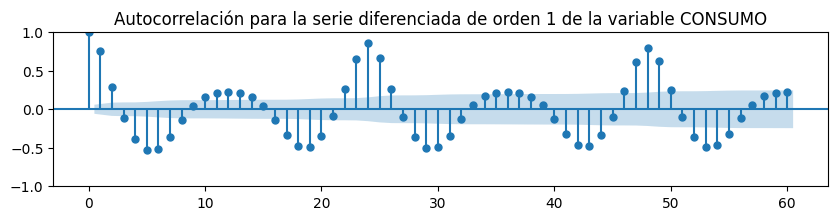

In [51]:
fig, ax = plt.subplots(figsize=(10, 2))

plot_acf(train_data_diff_1[variable], ax=ax, lags=60)
ax.set_title(f'Autocorrelación para la serie diferenciada de orden 1 de la variable {variable}')
plt.show()

Una caída brusca de la ACF después de unos pocos retardos indica que los datos tienen un orden autorregresivo finito. Sin embargo, la ACF muestra un patrón sinusoidal, lo cual podría indicar la presencia de una componente estacional. Las correlaciones significativas a múltiples lags indican que hay una dependencia temporal a lo largo del tiempo.

El lag en el que la ACF cruza el umbral de significancia proporciona una estimación del valor de $q$:

In [52]:
q = 3

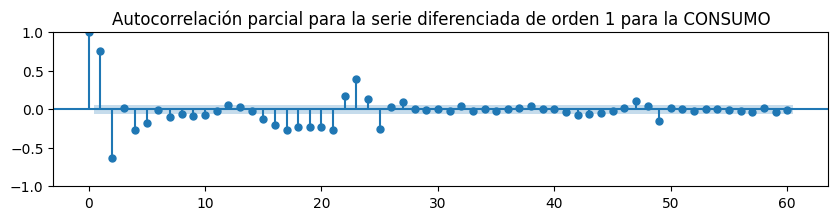

In [53]:
fig, ax = plt.subplots(figsize=(10, 2))
plot_pacf(train_data_diff_1[variable], ax=ax, lags=60, method='ywm')
ax.set_title(f'Autocorrelación parcial para la serie diferenciada de orden 1 para la {variable}')
plt.show()

En la gráfica de autocorrelación parcial (PACF), los primeros lags muestran correlaciones significativas, lo cual indica que hay una relación directa entre los valores actuales y los valores pasados en esos lags específicos.
Después de los primeros lags, las correlaciones se vuelven insignificantes rápidamente, hasta llegar a las siguientes 24h o 48h que vuelve a haber un pequeño repunte. Esto sugiere que seguramente exista estacionalidad en los datos.

Notar que los valores de la PACF caen dentro del umbral de no significancia a partir del lag 3, indicando que el modelo ARIMA podría tener un término AR:

In [54]:
p = 2

#### 5.2.2. Creación y entrenamiento del modelo

In [55]:
def modelo_ARIMA(train_data, test_data, p, d, q):
    params = {
        'order': (p, d, q)
    }
    modelo = ARIMA(**params)
    model_fit = modelo.fit(train_data[variable])
    predicciones = model_fit.predict(n_periods=len(test_data[variable]))
    forecast = model_fit.predict(n_periods=len(test_data[variable]), return_conf_int=False)

    metrics = all_metrics(predicciones, test_data, train_data)
    print(f"Métricas de error: {metrics}")

    fig, ax = plt.subplots(figsize=(11, 3))
    train_data[variable].plot(ax=ax, label='train')
    test_data[variable].plot(ax=ax, label='test')
    predicciones.plot(ax=ax, label='predicción')
    ax.set_title(f'Predicciones con ARIMA para la variable {variable}')
    ax.legend()

    return params, metrics

Métricas de error: {'MAE': 3393.9463322879496, 'MSE': 26736693.8767017, 'RMSE': 5170.75370489658}


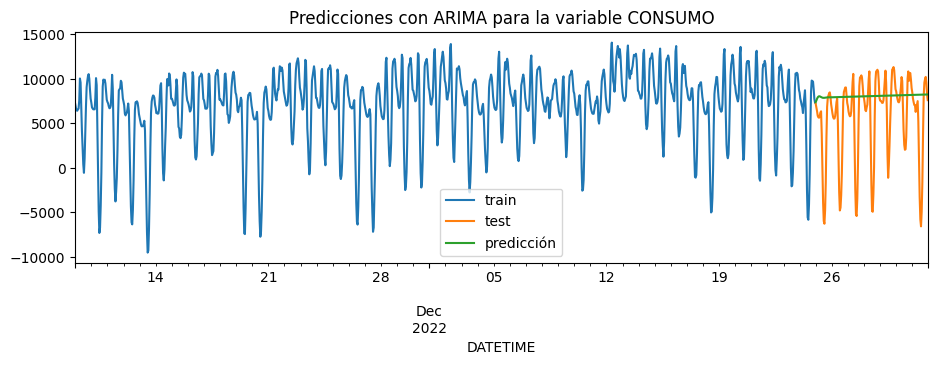

In [56]:
params, metrics = modelo_ARIMA(train_val_data, test_data, p, d, q)
tabla_comparacion_modelos = guardar_results(f'ARIMA({params})', metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

Los resultados con modelos ARIMA son muy malos, peores incluso que los obtenidos con el modelo baseline. Notar que las predicciones son casi planas. Puede que se deba a la existente estacionalidad de los datos. Deberemos modelar también la componente estacional con SARIMA.

### 5.3. SARIMA (Seasonal ARIMA)

SARIMA es una extensión de ARIMA que incluye componentes estacionales. Ideal para datos que muestran estacionalidad, como el consumo eléctrico que hemos visto que sigue un ciclo diario. SARIMA incorpora los siguientes términos (además de los que ya incluye ARIMA):

- $P$: Número de términos autorregresivos en la parte estacional del modelo.
- $D$: Número de veces que los datos deben ser diferenciados estacionalmente.
- $Q$: Número de términos de media móvil en la parte estacional del modelo.
- $s$: Longitud del ciclo estacional.

#### 5.3.1. Análisis exploratorio de la serie

Como hemos detectado que nuestras series tienen estacionalidad, será útil realizar una descomposición estacional de series temporales (STL), es decir, descomponer la serie temporal en sus componentes fundamentales para un análisis más detallado:

- La tendencia
- La estacionalidad
- Los residuos

Este análisis puede revelar patrones ocultos y ayudar a identificar la estacionalidad, además de los valores óptimos de los parámetros $P$, $D$, $Q$ y $s$ (y puede llevarse a cabo de manera aditiva o multiplicativa).

In [57]:
def descomposicion_estacional(df):
    res_decompose = seasonal_decompose(df[variable], model='additive', extrapolate_trend='freq')

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 7))
    res_decompose.observed.plot(ax=axs[0, 0])
    axs[0, 0].set_title('Serie')
    res_decompose.trend.plot(ax=axs[0, 1])
    axs[0, 1].set_title('Tendencia')
    res_decompose.seasonal.plot(ax=axs[1, 0])
    axs[1, 0].set_title('Estacionalidad')
    res_decompose.resid.plot(ax=axs[1, 1])
    axs[1, 1].set_title('Residuos')
    fig.suptitle(f'Descomposición estacional de la serie para la variable {variable}', fontsize=14)
    fig.tight_layout()

    return res_decompose

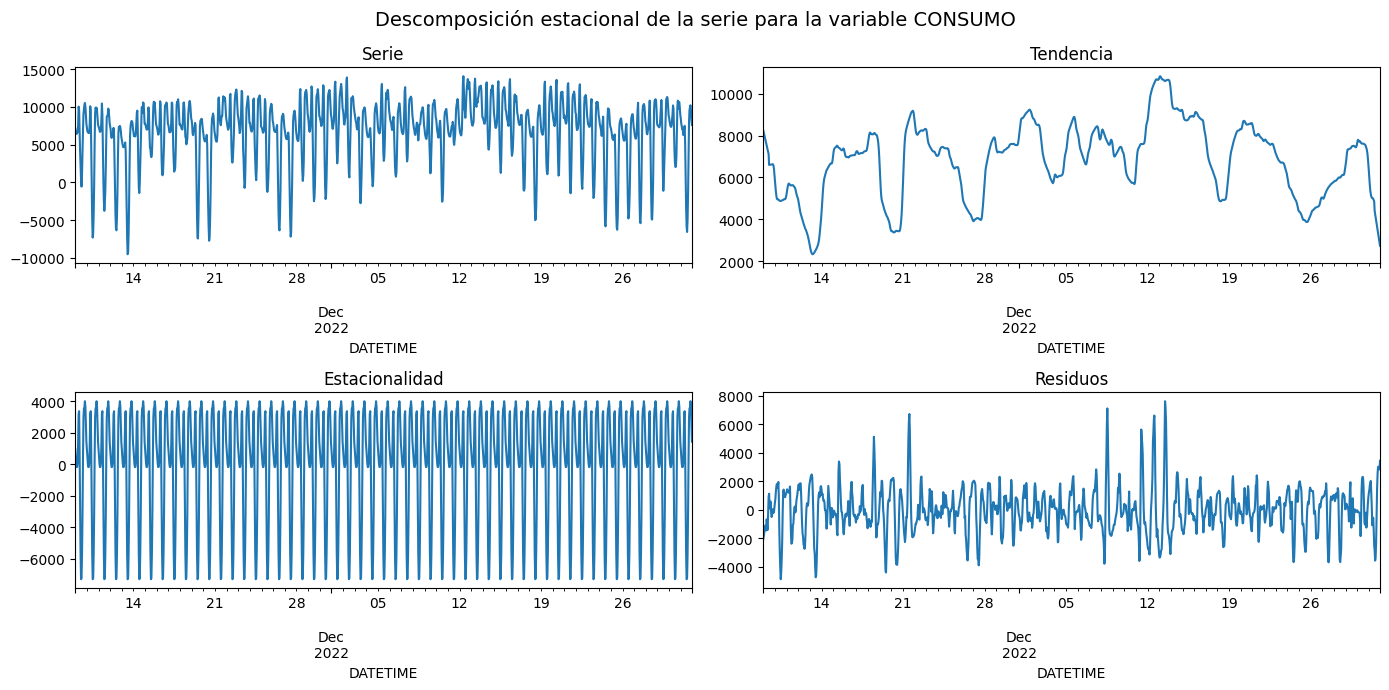

In [58]:
descomposicion_estacional(df_consumo_total)

- La estacionalidad muestra un patrón muy claro con ciclos regulares de 24 horas (lags) en las tres series temporales. De aquí se sigue el valor de s.

- En las gráficas de tendencia se puede apreciar una tendencia decreciente tanto en las variables CONSUMO como ENTRADA.

In [59]:
s = 24

(De esto se encarga SARIMA: Si queremos aplicar ARIMA, deberemos aplicar la diferenciación estacional. Esto captura patrones cíclicos o estacionales y ayuda a eliminar tendencias estacionales.)

#### 5.3.2. Creación y entrenamiento del modelo

In [60]:
def skforecast_SARIMAX(train_data, test_data, p, d, q, P, D, Q, s):
    params = {
        'order': (p, d, q),
        'seasonal_order': (P, D, Q, s)
    }
    modelo = Sarimax(**params)
    modelo.fit(y=train_data[variable])
    predicciones = modelo.predict(steps=len(test_data[variable]))
    metrics = all_metrics(predicciones, test_data, train_data)
    print(f"Métricas de error con skforecast: {metrics}")
    return params, predicciones, metrics

def pdmarima_SARIMAX(train_data, test_data, p, d, q, P, D, Q, s):
    params = {
        'order': (p, d, q),
        'seasonal_order': (P, D, Q, s)
    }
    modelo = ARIMA(**params)
    modelo.fit(y=train_data[variable])
    predicciones = modelo.predict(len(test_data[variable]))
    metrics = all_metrics(predicciones, test_data, train_data)
    print(f"Métricas de error con pdmarima: {metrics}")
    return params, predicciones, metrics

In [61]:
def modelos_SARIMA(train_data, test_data, p, d, q, P, D, Q, s):
    print(f'Predicciones con SARIMA para la serie de la variable {variable}')
    print('--------------------------------------------------------------')
    params1, preds1, metrics1 = skforecast_SARIMAX(train_data, test_data, p, d, q, P, D, Q, s)
    params2, preds2, metrics2 = pdmarima_SARIMAX(train_data, test_data, p, d, q, P, D, Q, s)

    fig, ax = plt.subplots(figsize=(10, 3))
    train_data[variable].plot(ax=ax, label='train')
    test_data[variable].plot(ax=ax, label='test')
    preds1.plot(ax=ax, label='skforecast')
    preds2.plot(ax=ax, label='pmdarima')
    ax.set_title(f'Predicciones con modelos SARIMA para la variable {variable}')
    ax.legend()

    return params1, params2, metrics1, metrics2

In [62]:
P, D, Q = 1,1,1

Predicciones con SARIMA para la serie de la variable CONSUMO
--------------------------------------------------------------
Métricas de error con skforecast: {'MAE': 2566.1706623393598, 'MSE': 10050569.23329721, 'RMSE': 3170.263275076253}
Métricas de error con pdmarima: {'MAE': 1666.1931955813748, 'MSE': 5212337.512269758, 'RMSE': 2283.0544260419542}


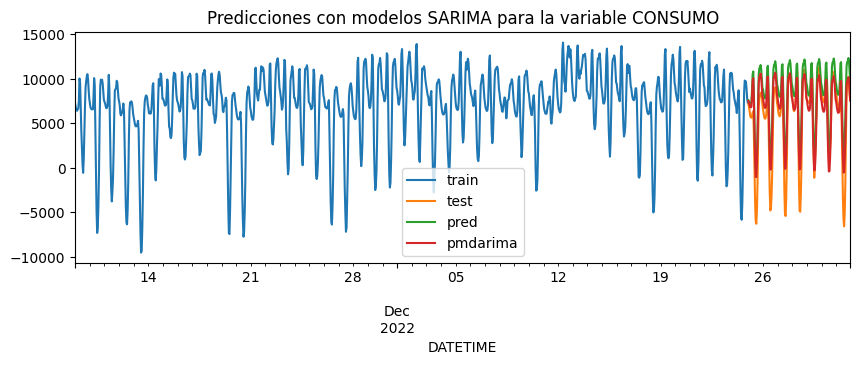

In [63]:
params1, params2, metrics1, metrics2 = modelos_SARIMA(train_val_data, test_data, p, d, q, P, D, Q, s)
tabla_comparacion_modelos = guardar_results(f'Sarimax({params1})', metrics1['MAE'], metrics1['MSE'], metrics1['RMSE'], tabla_comparacion_modelos)
tabla_comparacion_modelos = guardar_results(f'ARIMA({params2})', metrics2['MAE'], metrics2['MSE'], metrics2['RMSE'], tabla_comparacion_modelos)

Estos modelos SARIMA claramente dan mejores resultados que los ARIMA, pero no llegan a tener un MAE inferior al conseguido con el modelo baseline.

#### 5.3.3. ForecasterSarimax

Dado que ForecasterSarimax sigue la misma API que los otros Forecasters disponibles en la librería, es muy fácil hacer una comparación robusta del rendimiento de modelos ARIMA-SARIMAX frente a otros modelos de machine learning como Random Forest or Gradient Boosting. (https://cienciadedatos.net/documentos/py51-modelos-arima-sarimax-python)

In [64]:
params = {
        'order': (p, d, q),
        'seasonal_order': (P, D, Q, s)
    }
forecaster = ForecasterSarimax(regressor=Sarimax(**params)) #maxiter=200

In [65]:
metrics = backtesting(forecaster, df_consumo_total, train_val_data, test_data)
tabla_comparacion_modelos = guardar_results(f'ForecasterSarimax(regressor=Sarimax({params})', metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

  0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
params = {
        'order': (p, d, q),
        'seasonal_order': (P, D, Q, s)
    }
forecaster = ForecasterSarimax(regressor=ARIMA(**params)) #maxiter=200

In [ ]:
metrics = backtesting(forecaster, df_consumo_total, train_val_data, test_data)
tabla_comparacion_modelos = guardar_results(f'ForecasterSarimax(regressor=ARIMA({params})', metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

Seguimos consiguiendo reducir el MAE, pero no lo suficiente como para superar el modelo baseline todavía. Nos queda margen para ajustar los parámetros, sobre todo en $P$, $D$ y $Q$.

#### 5.3.4. Búsqueda exhaustiva de hiperparámetros

Para determinar los valores óptimos de los hiperparámetros del modelo, es mejor que utilizemos métodos de búsqueda estratégicos. Entre ellos podemos destacar los siguientes:

- Criterios estadísticos: Las métricas de criterios de información, como el Criterio de Información de Akaike (AIC), utilizan diferentes penalizaciones sobre la estimación de máxima verosimilitud del modelo como medida de la bondad de ajuste. Cabe destacar que se calculan únicamente con los datos de entrenamiento, lo cual permite que el proceso de optimización se acelere. Eso si, el modelo final seleccionado ha de someterse a una fase posterior de backtesting que valide su rendimiento. Como ejemplo tenemos el algoritmo Auto-ARIMA que utilizaremos a continuación.

- Técnicas de validación: como el backtesting, que consiste en evaluar el rendimiento del modelo utilizando datos históricos para simular las condiciones del mundo real. Esto ayuda a validar la eficacia de los hiperparámetros en diferentes escenarios y por lo tanto, los resultados generados suelen ser más robustos.

Dado que Auto-ARIMA es una estrategia de búsqueda de mucho más rápida, es una buena opción utilizarla como primer paso para identificar un grupo inicial de modelos candidatos. Para, posteriormente comparar los candidatos finales utilizando backtesting.

Nota: Es fundamental llevar a cabo la optimización de hiperparámetros utilizando un conjunto de datos de validación, en lugar del conjunto de datos de test.

##### ***Auto-ARIMA***

In [ ]:
def auto_ARIMA(df, train_data, d):
  buffer = StringIO()
  with contextlib.redirect_stdout(buffer):
      auto_arima(
              y                 = df[variable].loc[:train_data.index.max()],
              start_p           = 0,
              start_q           = 0,
              max_p             = 5,
              max_q             = 5,
              seasonal          = True,
              test              = 'adf',
              m                 = 24, # periodicidad de la estacionalidad
              d                 = d,
              D                 = None, # El algoritmo determina 'D'
              trace             = True,
              error_action      = 'ignore',
              suppress_warnings = True,
              stepwise          = True
          )
  trace_autoarima = buffer.getvalue()
  pattern = r"ARIMA\((\d+),(\d+),(\d+)\)\((\d+),(\d+),(\d+)\)\[(\d+)\]\s+(intercept)?\s+:\s+AIC=([\d\.]+), Time=([\d\.]+) sec"
  matches = re.findall(pattern, trace_autoarima)
  results = pd.DataFrame(matches, columns=["p", "d", "q", "P", "D", "Q", "s", "intercept", "AIC", "Time"])
  results["order"] = results[["p", "d", "q"]].apply(lambda x: f"({x.iloc[0]},{x.iloc[1]},{x.iloc[2]})", axis=1)
  results["seasonal_order"] = results[["P", "D", "Q", "s"]].apply(lambda x: f"({x.iloc[0]},{x.iloc[1]},{x.iloc[2]},{x.iloc[3]})", axis=1)
  results = results[["order", "seasonal_order", "intercept", "AIC", "Time"]]
  results["AIC"] = results["AIC"].astype('float64')
  results_auto_arima = results.sort_values(by="AIC").reset_index(drop=True)
  results_auto_arima.to_csv(f'/content/drive/MyDrive/TFM/auto_arima_{variable}.csv', index=False)

  return results_auto_arima

In [ ]:
try:
  results_auto_arima = pd.read_csv(f'/content/drive/MyDrive/TFM/auto_arima_{variable}.csv')
except FileNotFoundError:
  results_auto_arima = auto_ARIMA(df_consumo_total, train_val_data, None) #None

In [ ]:
results_auto_arima.head()

Calculemos las predicciones con el modelo indicado por auto-ARIMA:

In [ ]:
params = {
        'order': eval(results_auto_arima['order'][0]),
        'seasonal_order': eval(results_auto_arima['seasonal_order'][0])
    }
forecaster = ForecasterSarimax(regressor=Sarimax(**params)) #,maxiter=200

In [ ]:
metrics = backtesting(forecaster, df_consumo_total, train_val_data, test_data)
tabla_comparacion_modelos = guardar_results(f'ForecasterSarimax(regressor=Sarimax({params})', metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

+ Es importante tener en cuenta que el AIC asume que todos los modelos están entrenados con los mismos datos. Por lo tanto, usar el AIC para decidir entre diferentes órdenes de diferenciación es técnicamente inválido.
Así, vamos a aplicar de nuevo auto-ARIMA, pero fijando $d=1$ que es el valor óptimo de $d$ que habíamos encontrado antes.

In [ ]:
try:
  results_auto_arima = pd.read_csv(f'/content/drive/MyDrive/TFM/auto_arima_{variable}_2.csv')
except FileNotFoundError:
  results_auto_arima = auto_ARIMA(df_consumo_total, train_val_data, 1)

In [ ]:
results_auto_arima.head()

In [ ]:
params = {
        'order': eval(results_auto_arima['order'][0]),
        'seasonal_order': eval(results_auto_arima['seasonal_order'][0])
    }
forecaster = ForecasterSarimax(regressor=Sarimax(**params)) #,maxiter=200

In [ ]:
metrics = backtesting(forecaster, df_consumo_total, train_val_data, test_data)
tabla_comparacion_modelos = guardar_results(f'ForecasterSarimax(regressor=Sarimax({params})', metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

##### ***GridSearch***

In [ ]:
# def grid_search_sarimax(forecaster, param_grid, df, train_data, validation_data):
#     resultados_grid = grid_search_sarimax(
#                             forecaster            = forecaster,
#                             y                     = df[variable].loc[:validation_data.index.max()],
#                             param_grid            = param_grid,
#                             steps                 = 12,
#                             refit                 = True,
#                             metric                = 'mean_absolute_error',
#                             initial_train_size    = len(train_data[variable]),
#                             fixed_train_size      = False,
#                             return_best           = False,
#                             n_jobs                = 'auto',
#                             suppress_warnings_fit = True,
#                             verbose               = False,
#                             show_progress         = True
#                        )
#     return resultados_grid

In [ ]:
# forecaster = ForecasterSarimax(regressor=Sarimax(order=(2, 1, 4), maxiter=500))
# param_grid = {
#     #'order': [(2, 1, 4)],
#     'seasonal_order': [(1, 0, 0, 24), (1, 1, 0, 24), (1, 0, 1, 24), (0, 1, 0, 24), (0, 0, 1, 24), (1, 1, 1, 24)]#,
#     #'trend': [None, 'n', 'c']
# }

In [ ]:
# resultados_grid = grid_search_sarimax(forecaster, param_grid, df_consumo_total, train_data, validation_data)

### 5.4. Modelo autoregresivo recursivo con Gradient Boosting Machines (GBM): LGBMRegressor

#### 5.4.1. Creación y entrenamiento del modelo

Se entrena un modelo autorregresivo recursivo (ForecasterAutoreg) con gradient boosting LGBMRegressor como regresor. Se utiliza una ventana temporal de 24 horas (24 lags) para predecir la demanda de la hora siguiente. Esto significa que los valores de demanda de las 24 horas anteriores se utilizan como predictores. Los hiperparámetros del regresor se dejan en sus valores por defecto.

In [ ]:
forecaster_ar_base = ForecasterAutoreg(regressor = LGBMRegressor(random_state=1, verbose = -1, verbose_eval = False), lags = 24) #, max_depth=2, learning_rate=0.1, n_estimators=50
#incorporar como predictores(aquí los últimos 24 valores(horas))
#si le damos una serie: [1, 2, 3, 24] utiliza las 3 horas anteriores y la hora 24

In [ ]:
metrics = backtesting(forecaster_ar_base, df_consumo_total, train_val_data, test_data)

#### 5.4.2. Búsqueda bayesiana de hiperparámetros

*ForecasterAutoreg* tiene mucho hiperparámetros. De forma que, encontrando los mejores, podremos obtener predicciones más precisas. La búsqueda de estos hiperparámetros, se realiza mediante una Búsqueda Bayesiana con la función *bayesian_search_forecaster()*. Es importante señalar que la búsqueda de hiperparámetros debe realizarse utilizando el conjunto de validación, nunca con los datos de test.

La búsqueda se realiza probando cada combinación de hiperparámetros y retardos del siguiente modo:

1. Entrenar el modelo utilizando sólo el conjunto de entrenamiento.

2. El modelo se evalúa utilizando el conjunto de validación mediante backtesting.

3. Seleccionar la combinación de hiperparámetros y retardos que proporcione el menor error.

4. Volver a entrenar el modelo con la mejor combinación encontrada, esta vez utilizando tanto los datos de entrenamiento como los de validación.

In [ ]:
lags_grid = [24, [1, 2, 3, 23, 24, 25, 167, 168, 169]]

def search_space(trial):
    max_depth = trial.suggest_int('max_depth', 3, 10, step=1)
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'     : max_depth,
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'num_leaves'     : trial.suggest_int('num_leaves', 2 ** max_depth, max(31, 2 ** max_depth), step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25)
    }
    return search_space

def bayesian_search(forecaster, df, train_data, validation_data, search_space):
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    resultados_busqueda, frozen_trial = bayesian_search_forecaster(
                                              forecaster         = forecaster,
                                              y                  = df.loc[:validation_data.index.max(), variable], # Datos test no incluidos
                                              steps              = 24,
                                              metric             = 'mean_absolute_error',
                                              search_space       = search_space,
                                              lags_grid          = lags_grid,
                                              initial_train_size = len(train_data),
                                              refit              = False,
                                              n_trials           = 20, # Aumentar para una búsqueda más exhaustiva
                                              random_state       = 123,
                                              return_best        = True,
                                              n_jobs             = 'auto',
                                              verbose            = False,
                                              show_progress      = True
                                          )
    return resultados_busqueda

In [ ]:
try:
  forecaster_bs = joblib.load(f'/content/drive/MyDrive/TFM/forecaster_bs_{variable}.pkl')
except FileNotFoundError:
  forecaster_bs = forecaster_ar_base
  results_bayesian_search = bayesian_search(forecaster_bs, df_consumo_total, train_data, validation_data, search_space)
  joblib.dump(forecaster_bs, f'/content/drive/MyDrive/TFM/forecaster_bs_{variable}.pkl')

#### 5.4.3. Backtesting del modelo con los hiperparámetros óptimos

Apliquemos ahora backtesting al modelo, utilizando los datos de train y validación como train.

In [ ]:
metrics = backtesting(forecaster_bs, df_consumo_total, train_val_data, test_data)
tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_bs.regressor}), lags = {forecaster_bs.lags}', metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

##### Forecaster direct multi-step

El modelo que hemos utilizado ForecasterAutoreg sigue una estrategia recursiva, de forma que cada nueva predicción se basa en las anteriores.
Sin embargo, podemos utilizar también el modelo ForecasterAutoregDirect, que sigue una estrategia direct multi-step forecasting y, aunque es más costosa computacionalmente debido a la necesidad de entrenar múltiples modelos, puede dar mejores resultados.

In [ ]:
forecaster_direct = ForecasterAutoregDirect(regressor = LGBMRegressor(**forecaster_bs.regressor.get_params()), lags = forecaster_bs.lags, steps = 24)
metrics = backtesting(forecaster_direct, df_consumo_total, train_val_data, test_data)
tabla_comparacion_modelos = guardar_results(f'ForecasterAutoregDirect(regressor = {forecaster_direct.regressor}), lags = {forecaster_direct.lags}',  metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

### 5.5. Modelo autoregresivo recursivo con Gradient Boosting Machines (GBM): XGBoost (descaratdo??)

### 5.5. Árboles de Decisión y Random Forest

#### 5.5.1. Creación y entrenamiento del modelo

In [ ]:
forecaster_ar_rf = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),lags = 1008)

In [ ]:
metrics = backtesting(forecaster_ar_rf, df_consumo_total, train_val_data, test_data)
tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),lags = 1008)',  metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

#### 5.5.2. Ajuste de hiperparámetros (tuning)



In [ ]:
def grid_search_ar(forecaster, steps, lags_grid, param_grid, train_data):
  resultados_grid = grid_search_forecaster(
                          forecaster         = forecaster,
                          y                  = train_data[variable],
                          param_grid         = param_grid,
                          lags_grid          = lags_grid,
                          steps              = steps,
                          refit              = False,
                          metric             = 'mean_squared_error',
                          initial_train_size = int(len(train_data)*0.5),
                          fixed_train_size   = False, #el conjunto de entrenamiento crece a medida que se avanza en el tiempo.
                          return_best        = True,
                          n_jobs             = 'auto',
                          verbose            = False
                    )

In [ ]:
steps = 24
lags_grid = [10, 30]
param_grid = {
      'n_estimators': [100, 250],
      'max_depth': [3, 5, 10]
}
grid_search_ar(forecaster_ar_rf, steps, lags_grid, param_grid, train_data)

#### 5.5.3. Backtesting

In [ ]:
metrics = backtesting(forecaster_ar_rf, df_consumo_total, train_val_data, test_data)
tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_rf.regressor}), lags = {forecaster_ar_rf.lags}',  metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

### 5.7. Redes Neuronales Recurrentes (RNN) (no merece)

Redes que son muy buenas para datos secuenciales. Adecuadas para capturar dependencias temporales en los datos de consumo.

In [71]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

scaler = MinMaxScaler(feature_range=(0, 1))
data = df_consumo_total['CONSUMO'].values.reshape(-1, 1)
scaled_data = scaler.fit_transform(data)
look_back = 10
# Crear el TimeseriesGenerator
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]
train_generator = TimeseriesGenerator(train_data, train_data, length=look_back, batch_size=1)
test_generator = TimeseriesGenerator(test_data, test_data, length=look_back, batch_size=1)

# Definir el modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(train_generator, epochs=100, verbose=2)
train_predict = model.predict(train_generator)
test_predict = model.predict(test_generator)

# Invertir la escala de las predicciones
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(train_data[look_back:])
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(test_data[look_back:])

train_metrics = all_metrics(train_predict, train_actual)
test_metrics = all_metrics(test_predict, test_actual)

print(f'Métricas de entrenamiento: {train_metrics}')
print(f'Métricas de prueba: {test_metrics}')

Epoch 1/100
1007/1007 - 17s - loss: 0.0244 - 17s/epoch - 17ms/step
Epoch 2/100
1007/1007 - 9s - loss: 0.0033 - 9s/epoch - 9ms/step
Epoch 3/100
1007/1007 - 9s - loss: 0.0018 - 9s/epoch - 9ms/step
Epoch 4/100
1007/1007 - 9s - loss: 0.0017 - 9s/epoch - 9ms/step
Epoch 5/100
1007/1007 - 8s - loss: 0.0015 - 8s/epoch - 8ms/step
Epoch 6/100
1007/1007 - 10s - loss: 0.0016 - 10s/epoch - 10ms/step
Epoch 7/100
1007/1007 - 9s - loss: 0.0016 - 9s/epoch - 9ms/step
Epoch 8/100
1007/1007 - 8s - loss: 0.0016 - 8s/epoch - 8ms/step
Epoch 9/100
1007/1007 - 11s - loss: 0.0014 - 11s/epoch - 11ms/step
Epoch 10/100
1007/1007 - 9s - loss: 0.0015 - 9s/epoch - 9ms/step
Epoch 11/100
1007/1007 - 10s - loss: 0.0014 - 10s/epoch - 9ms/step
Epoch 12/100
1007/1007 - 8s - loss: 0.0014 - 8s/epoch - 8ms/step
Epoch 13/100
1007/1007 - 9s - loss: 0.0014 - 9s/epoch - 9ms/step
Epoch 14/100
1007/1007 - 8s - loss: 0.0014 - 8s/epoch - 8ms/step
Epoch 15/100
1007/1007 - 8s - loss: 0.0014 - 8s/epoch - 8ms/step
Epoch 16/100
1007/1007 

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# # Procesado de datos
# # ==============================================================================
# import pandas as pd
# import numpy as np
# from skforecast.datasets import fetch_dataset

# # Gráficos
# # ==============================================================================
# import matplotlib.pyplot as plt
# from skforecast.plot import set_dark_theme
# set_dark_theme()
# import plotly.express as px
# import plotly.graph_objects as go
# import plotly.io as pio
# import plotly.offline as poff
# pio.templates.default = "seaborn"
# poff.init_notebook_mode(connected=True)

# # Tensorflow and Keras
# # ==============================================================================
# import tensorflow
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import MeanSquaredError
# from tensorflow.keras.callbacks import EarlyStopping

# # Modelado series temporales
# # ==============================================================================
# import skforecast
# from skforecast.ForecasterRnn import ForecasterRnn
# from skforecast.ForecasterRnn.utils import create_and_compile_model
# from sklearn.preprocessing import MinMaxScaler
# from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries


In [ ]:
# # Creación del modelo
# # ==============================================================================
# series = [variable] # Series temporales que se utilizarán para entrenar el modelo.
# levels = [variable] # Serie que se quiere predecir
# lags = 24 # Valores pasados a utilizar en la predicción
# steps = 168 # Pasos a futuro a predecir

# data = df_consumo_total[series].copy()
# data_train = train_data[series].copy()
# data_val = validation_data[series].copy()
# data_test = test_data[series].copy()


# model = create_and_compile_model(
#     series=data_train,
#     levels=levels,
#     lags=lags,
#     steps=steps,
#     recurrent_layer="LSTM",
#     recurrent_units=4,
#     dense_units=16,
#     optimizer=Adam(learning_rate=0.01),
#     loss=MeanSquaredError()
# )
# model.summary()

In [ ]:
# # Creación del forecaster
# # ==============================================================================
# forecaster = ForecasterRnn(
#     regressor=model,
#     levels=levels,
#     transformer_series=MinMaxScaler(),
#     fit_kwargs={
#         "epochs": 10,  # Número de épocas para entrenar el modelo.
#         "batch_size": 32,  # Tamaño del batch para entrenar el modelo.
#         "callbacks": [
#             EarlyStopping(monitor="val_loss", patience=5)
#         ],  # Callback para detener el entrenamiento cuando ya no esté aprendiendo más.
#         "series_val": data_val,  # Datos de validación para el entrenamiento del modelo.
#     },
# )
# forecaster

In [ ]:
# # Backtesting con datos de test
# # ==============================================================================
# metrics, predictions = backtesting_forecaster_multiseries(
#     forecaster=forecaster,
#     steps=forecaster.max_step,
#     series=data,
#     levels=forecaster.levels,
#     initial_train_size=len(data.loc[:validation_data.index.max(), :]), # Datos de entrenamiento + validación
#     metric="mean_absolute_error",
#     verbose=False,
#     refit=False,
# )

In [ ]:
# metrics

## 6. Evaluación de los modelos

In [ ]:
tabla_comparacion_modelos.sort_values(by='MAE', ascending = True)
tabla_comparacion_modelos.to_csv(f'/content/drive/MyDrive/TFM/tabla_comparacion_modelos_{variable}.csv')

### 6.1. Variables exógenas

Añadamos ahora al modelo las variables exógenas que hemos considerado anteriormente en nuestro conjunto de datos.
Como ahora se incluyen muchas más variables en el modelo, es posible que los hiperparámetros identificados previamente ya no sean óptimos, por lo que se realiza una nueva búsqueda. Esta vez, sin embargo, la búsqueda se adapta al rango de valores identificados en la búsqueda anterior.

In [ ]:
# def backtesting_con_exog(forecaster, df, train_data, test_data, exog_cols):
#   metric, predictions = backtesting_forecaster(
#                           forecaster         = forecaster,
#                           y                  = df[variable],
#                           exog               = df[exog_cols],
#                           steps              = 24,
#                           metric             = 'mean_absolute_error',
#                           initial_train_size = len(df[variable].loc[:train_data.index.max()]),
#                           refit              = False,
#                           n_jobs             = 'auto',
#                           verbose            = False,
#                           show_progress      = True
#                     )
#   metrics = all_metrics(predictions, test_data, train_data)
#   print(f"Métricas de error: {metrics}")

#   fig, ax = plt.subplots(figsize=(11, 3))
#   train_data[variable].plot(ax=ax, label='train')
#   test_data[variable].plot(ax=ax, label='test')
#   predictions.plot(ax=ax, label='predicciones')
#   ax.set_title(f'Predicción sobre la variable {variable} con variables exógenas')
#   ax.legend()

#   return predictions, metrics

In [ ]:
# predictions, metrics = backtesting_con_exog(forecaster, df_consumo_total, train_val_data, test_data, exog_cols)
# tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster.regressor}), lags = {forecaster.lags} y variables exog', metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

In [ ]:
# se puede hacer bayesian search de nuevo

# forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123), lags = 24)
# forecaster.fit(y=train_val_data[variable], exog=train_val_data[exog_cols])
# predicciones = forecaster.predict(steps=168, exog=test_data[exog_cols])

# fig, ax = plt.subplots(figsize=(6, 2.5))
# #train_val_data[variable].plot(ax=ax, label='train')
# test_data[variable].plot(ax=ax, label='test')
# predicciones.plot(ax=ax, label='predicciones')
# ax.legend()

In [ ]:
#Backtesting en los datos de test incluyendo las variables exógenas

### 6.2. Explicabilidad

#### 6.2.1. Importancia predictores

In [ ]:
# def importancia_features(forecaster, df, train_data):
#   forecaster.fit(y = df.loc[:train_data.index.max(), variable], exog = df.loc[:train_data.index.max(), exog_cols])
#   feature_importances = forecaster.get_feature_importances()
#   feature_importances.sort_values(by='importance', ascending=False).head(10)

In [ ]:
# importancia_features(forecaster, df_consumo_total, train_val_data)

#### 6.2.2. Shap values

Se puede obtener un análisis SHAP a partir de modelos skforecast con sólo dos elementos:

- El regresor interno del forecaster.

- Las matrices de entrenamiento creadas a partir de la serie temporal y variables exógenas, utilizadas para ajustar el pronosticador.



In [ ]:
# def shap_values(forecaster, train_data):
#   X_train, y_train = forecaster.create_train_X_y(y=train_val_data[variable]) # Matrices de entrenamiento utilizadas por el forecaster para entrenar el regresor

#   params = forecaster.regressor.get_params()
#   params['predict_disable_shape_check'] = True
#   forecaster.regressor = LGBMRegressor(**params)
#   forecaster.regressor.fit(X_train, y_train)

#   explainer = shap.TreeExplainer(forecaster.regressor)
#   # Se selecciona una muestra del 50% de los datos para acelerar el cálculo
#   rng = np.random.default_rng(seed=785412)
#   sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False)
#   X_train_sample = X_train.loc[sample, :]
#   shap_values = explainer.shap_values(X_train_sample)

#   shap.initjs()
#   shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)
#   fig, ax = plt.gcf(), plt.gca()
#   ax.set_title("SHAP Summary plot")
#   ax.tick_params(labelsize=8)
#   fig.set_size_inches(6, 3.5)
#   plt.show()

In [ ]:
# shap_values(forecaster, train_data)

## 7. Predicciones

# BORRADOR

## 3. Series temporales

- Librería datetime: df.Fecha = pd.to_datetime(df.Fecha)
- Si Df.set_index(‘Fecha’, inplace = True)
    -> Podemos extraer el año, mes (df.index.year o df.index.month)
    -> Podemos extraer el nombre del mes o del día (df.index.day_name(‘es’))
- Se puede indexar facilmente con el método loc:
    -> Obtener los datos de un mes: df.loc['2021-08']
    -> Entre dos fechas: df.loc['2021-07-29':2021-08-03']
- rolling(): para window calculations(por ejemplo hacer la media de siete dias juntos)
- Para sacar acumulados para cada mes por ejemplo: df_groupby(df.index.month_name('es'),sort = False).sum()
- Para calcular %: df['percent'] = df['casos'].apply(lamba x: round(x*100/total,2))

## 6. Ejemplo: predicción de la demanda con skforecast

### 6.4 Modelo autoregresivo recursivo

#### 6.4.2 Backtesting

#### 6.4.3 Intervalos de predicción

In [ ]:
# # Backtesting con intervalos de predicción
# # ==============================================================================
# metrica, predicciones = backtesting_forecaster(
#                             forecaster         = forecaster,
#                             y                  = datos['Demand'],
#                             initial_train_size = len(datos.loc[:fin_validacion]),
#                             steps              = 24,
#                             interval           = [5,95], #intervalo del 90%
#                             n_boot             = 100,
#                             metric             = 'mean_absolute_error',
#                             refit              = False,
#                             verbose            = False,
#                         )
# predicciones.head()

In [ ]:
# # Gráfico
# # ==============================================================================
# fig, ax = plt.subplots(figsize=(15,5))
# datos.loc[predicciones.index, 'Demand'].plot(ax=ax, linewidth=2, label='test')
# predicciones['pred'].plot(label='predicciones', ax=ax)
# ax.fill_between(
#     predicciones.index,
#     predicciones['lower_bound'],
#     predicciones['upper_bound'],
#     color = 'red',
#     alpha = 0.2
# )
# ax.legend();